# Detailed walkthrough

In this tutorial, we will try to cover any basic code to get our hands on Perceval.


## I. Introduction <a class="anchor" id="introduction"></a>

### 1. Perceval installation <a name="installation"></a>

In [2]:
# If needed, install perceval
#!pip install perceval-quandela~=0.9.1 -U

In [3]:
import perceval as pcvl
import numpy as np
import sympy as sp

## Use the symbolic skin for display
from perceval.rendering.circuit import DisplayConfig, SymbSkin
DisplayConfig.select_skin(SymbSkin)

### 2. BasicStates <a name="basicstates"></a>

In Linear Optical Circuits, photons can have many discrete degrees of freedom, called modes. 
It can be the frequency, the polarisation, the position, or all of them.

We represent these degrees of freedom with Fock states. If we have $n$ photons over $m$ modes, the Fock state $|s_1,s_2,...,s_m\rangle$ means we have $s_i$ photons in the $i^{th}$ mode. Note that $\sum_{i=1}^m s_i =n$.

In Perceval, we will use the module `pcvl.BasicState`

In [4]:
## Syntax of different BasicState (list, string, etc)
bs1 = pcvl.BasicState('|0,2,0,1>')
bs2 = pcvl.BasicState([0, 2, 0, 1])

if bs1==bs2:
    print("Those are the same states")

## You can iterate on modes
for i, photon_count in enumerate(bs2):
    print(f"There is {photon_count} photon in mode {i}")



Those are the same states
There is 0 photon in mode 0
There is 2 photon in mode 1
There is 0 photon in mode 2
There is 1 photon in mode 3


### 3. LO-Components <a name="components"></a>

The linear optical components are the elementary blocks which will act on our Fock states.

It's important to know all the possible components that can be found in Perceval and understand their effects.



PERM
PERM([2, 0, 1])


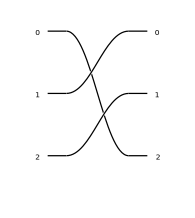

In [5]:
from perceval.components.unitary_components import PS, BS, PERM

## Permutation

perm=PERM([2,0,1])

print(perm.name)
print(perm.describe())
pcvl.pdisplay(perm.definition())
pcvl.pdisplay(perm)

PS
PS(phi=pi)


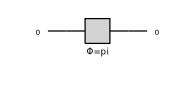

In [6]:
## Phase shifter
ps = PS(phi=np.pi)

print(ps.name)
print(ps.describe())  
pcvl.pdisplay(ps.definition()) 
pcvl.pdisplay(ps)  # A pdisplay call on a circuit/processor needs to be the last line of a cell


BS.Rx() unitary matrix


BS.H() unitary matrix


BS.Ry() unitary matrix


BS displays its convention as a small label


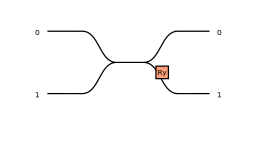

In [7]:
## Beam splitters
bs_rx = BS.Rx()  # By default a beam splitter follows the Rx gate convention, so bs=BS() has the same matrix

# But other conventions exist too:
bs_h = BS.H() 
bs_ry = BS.Ry()

## Check the difference in the unitary definition:
print("BS.Rx() unitary matrix")
pcvl.pdisplay(bs_rx.definition())
print("BS.H() unitary matrix")
pcvl.pdisplay(bs_h.definition())
print("BS.Ry() unitary matrix")
pcvl.pdisplay(bs_ry.definition())
print("BS displays its convention as a small label")
pcvl.pdisplay(bs_ry)

#### Assigning parameter values to components

In [8]:
# You can ask for the symbolic matrix value of your component with the attribute U
my_ps = PS(phi=sp.pi/8)
pcvl.pdisplay(my_ps.U)
# And for the numerical value with the method compute_unitary
pcvl.pdisplay(my_ps.compute_unitary())

#  - by using the syntax pcvl.P to create a symbolic variable 
#    (note that you cannot compute the numerical value of your component anymore)
print("A Phase Shifter with a symbolic value for phi:")
ps = PS(phi=pcvl.P('\psi'))
pcvl.pdisplay(ps.U)

A Phase Shifter with a symbolic value for phi:


In [9]:
# If you do it for a Beam-Splitter, you can see that by default theta=pi/2, and the phi's are 0
print("A default beam-splitter:")
pcvl.pdisplay(BS().compute_unitary())  #this is a balanced Beamsplitter
print("")

# To control the value of the parameters of a component, several choices are possible: 
#  - by setting a numerical value during the creation of the component
print("A Beam-Splitter with a numerical value for theta:")
bs_rx = BS.Rx(theta=10)
pcvl.pdisplay(bs_rx.compute_unitary())
print("")

#  - you can still modify the value of a symbolic variable after its creation
#    This is not true for a numerical variable!
print("A beam-splitter with a symbolic variable...")
bs_rx = BS(theta=pcvl.P('toto'))
pcvl.pdisplay(bs_rx.U)
bs_rx.assign({'toto':5})
bs_rx.assign({'toto':10})
print("... set to a numerical value")
pcvl.pdisplay(bs_rx.compute_unitary())
print("")

A default beam-splitter:



A Beam-Splitter with a numerical value for theta:



A beam-splitter with a symbolic variable...


... set to a numerical value


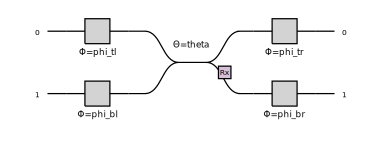

In [10]:
## to understand the conventions, you can note that a BS.Rx with the 4 phases phi (top left/right and bottom left/right) can be represented like that 

bs_rx_circuit = pcvl.Circuit(2) // (0,PS(phi=pcvl.P("phi_tl"))) // (1,PS(phi=pcvl.P("phi_bl"))) // BS(theta=pcvl.P('theta')) // (0,PS(phi=pcvl.P("phi_tr"))) // (1,PS(phi=pcvl.P("phi_br")))

pcvl.pdisplay(bs_rx_circuit.U)

# we can check it's the same as bs_rx.definition()
pcvl.pdisplay(bs_rx_circuit)

## For this cell, we needed the syntax to builds circuits... Good transition !

## II. LO-Circuits <a class="anchor" id="circuits"></a>

From the LO-components, we can build a LO-circuit, i.e. a sequence of those components acting on our different modes.

### 1. Syntax

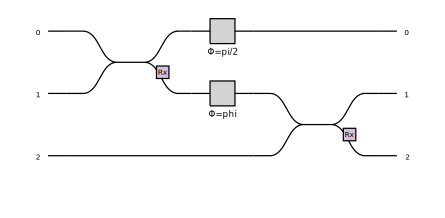

In [9]:
circuit = pcvl.Circuit(3)  # Create a 3 mode circuit


circuit.add(0, BS())  # The beam splitter is added to the circuit on mode 0 and 1
                      # even though only the first mode is required in `add` method

circuit.add(0, PS(phi=np.pi/2)).add(1, PS(phi=pcvl.P('phi'))).add(1, BS())

# Equivalent syntax:
# circuit // BS() // PS(phi=np.pi/2) // (1, PS(phi=pcvl.P('phi'))) // (1, BS())

pcvl.pdisplay(circuit.U)
pcvl.pdisplay(circuit)

The syntax ``pcvl.P('phi')`` allows you to use parameters in the circuit, where you can assign a value or not. The behavior of the parameters of a circuit is similar to the case of the components.

For instance, you can use :

[Parameter(name='phi', value=None, min_v=0.0, max_v=6.283185307179586)]


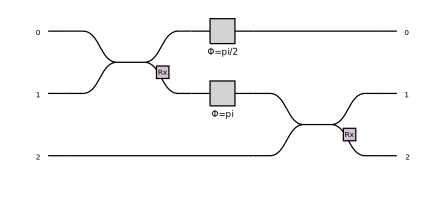

In [10]:
params=circuit.get_parameters()
print(params) #list of the parameters

# the value is None, but we can change that with :
params[0].set_value(np.pi)

pcvl.pdisplay(circuit)

### 2. Mach-Zehnder Interferometers

The beamsplitter's angle $\theta$ can also be defined as a parameter.

However, as the reflexivity depends on the mirror, it's hard to have adaptibility on the angle. 
Therefore, in practice, we use a [Mach-Zehnder Interferometer](https://en.wikipedia.org/wiki/Mach%E2%80%93Zehnder_interferometer). 

The beamsplitter with a parameterised $\theta$ is therefore implemented with a parameterised phase shifter $\phi$ between two fixed beamsplitters.




In [ ]:
## TO-DO: build a circuit implementing the mzi

mzi = #...

pcvl.pdisplay(mzi)

## TO-DO: Check that the parameterised phase allows you to change the reflectivity of your MZI

import matplotlib.pyplot as plt

## We create a list of all different values for theta
X=np.linspace(0,2*np.pi,1000)
Y=[]
for theta in X:
    # Assign theta value to the phase shifter in the MZI circuit you built
    #...
    Y.append(abs(mzi.compute_unitary()[0,0])**2)
   
plt.plot(X,Y)
plt.xlabel("phi")
plt.ylabel("R")
plt.show()

## Note: If you need to create a BS directly from the reflexivity value, please use:
## BS(BS.r_to_theta(reflectivity_value))
## However, be aware that only theta value is stored inside the BS object

### 3. Universal Circuits

An operation on the modes of our circuit can also be expressed as a unitary.

For three modes, the unitary $U=\begin{pmatrix}
a_{1,1} & a_{1,2} & a_{1,3}\\
a_{2,1} & a_{2,2} & a_{2,3} \\ 
a_{3,1} & a_{3,2} & a_{3,3}
\end{pmatrix}$ performs the following operation on the Fock state basis:

$$\begin{array}{rcl}
|1,0,0\rangle &  \mapsto&  a_{1,1}|1,0,0\rangle + a_{1,2}|0,1,0\rangle + a_{1,3}|0,0,1\rangle\\
|0,1,0\rangle &  \mapsto&  a_{2,1}|1,0,0\rangle + a_{2,2}|0,1,0\rangle + a_{2,3}|0,0,1\rangle\\
|0,0,1\rangle &  \mapsto&  a_{3,1}|1,0,0\rangle + a_{3,2}|0,1,0\rangle + a_{3,3}|0,0,1\rangle
\end{array}$$

Since 1994, we know that any $U$ on the modes can be implemented as an LO-circuit [Reck's et al](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.73.58).

This decomposition can be done easily in Perceval using beamsplitters and phase-shifters as follows. 

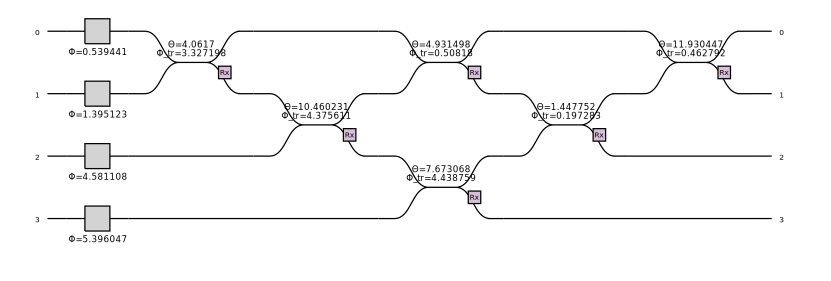

In [12]:
## From any unitary
n = 4
U = pcvl.Matrix.random_unitary(n)

decomposed_circuit = pcvl.Circuit.decomposition(U,BS(theta=pcvl.P('theta'),phi_tr=pcvl.P('phi')),phase_shifter_fn=PS)
pcvl.pdisplay(decomposed_circuit)

In [13]:
print("The error between the two unitaries is", np.linalg.norm(U - decomposed_circuit.compute_unitary()))

The error between the two unitaries is 9.735894441000613e-09


In [ ]:
## TO-DO: decompose the same unitary with MZIs built from phase shifters and balanced beamsplitters
# Note: the phase is on the right of the MZI, as the full layer of phases is on the left of the circuit
mzi = pcvl.Circuit(2) // BS() // PS(pcvl.P("phi1")) //  BS()  //  PS(pcvl.P("phi2"))

decomposed_circuit = #...


In [ ]:
## check the norm of the difference to be sure it has worked well
print("The error between the two unitaries is", np.linalg.norm(U - decomposed_circuit.compute_unitary()))

### 4. Black Box

To improve readibility, the circuit can be constructed in multiple steps which are then combined as black boxes. This will also help when we'll need generic operations.


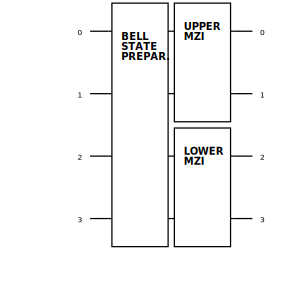

In [14]:
pre_MZI = (pcvl.Circuit(4, name="Bell State Prepar.")
           .add(0, BS())
           .add(2, BS())
           .add(1, PERM([1, 0])))

upper_MZI = (pcvl.Circuit(2, name="upper MZI")
             .add(0, PS(phi=pcvl.P('phi_0')))
             .add(0, BS())
             .add(0, PS(phi=pcvl.P('phi_2')))
             .add(0, BS()))

lower_MZI = (pcvl.Circuit(2, name="lower MZI")
             .add(0, PS(phi=pcvl.P('phi_1')))
             .add(0, BS())
             .add(0, PS(phi=pcvl.P('phi_3')))
             .add(0, BS()))

chip = (pcvl.Circuit(4)
              .add(0, pre_MZI)
              .add(0, upper_MZI, merge=False)
              .add(2, lower_MZI, merge=False))

pcvl.pdisplay(chip)

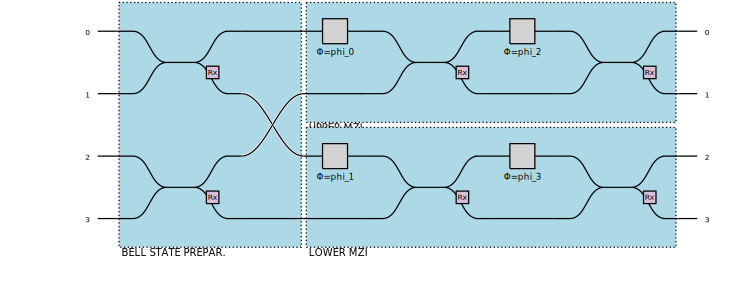

In [15]:
## You can still display the inside of black boxes with:
pcvl.pdisplay(chip, recursive=True)

## III. Simulation <a name="simulation"></a>

Up to this point, we have focused on creating circuits.
It's time to learn how to sample from them or describe their output distribution, on many different inputs.



### 1. Computing probabilities

For this part, we will take the [Hong-Ou-Mandel](https://en.wikipedia.org/wiki/Hong%E2%80%93Ou%E2%80%93Mandel_effect) experience as an example.

It's one of the simplest experiments and yet it is very useful.

Making two indistinguishable photons, one in each mode, enter one balanced beamsplitter $BS=\frac{1}{\sqrt{2}} \left[\begin{matrix}1 & 1\\1& -1\end{matrix}\right]$, we expect the outcome to be:

$$|1,1\rangle \mapsto \frac{|2,0\rangle - |0,2\rangle}{\sqrt{2}}  $$

We will show how to verify this in the next steps using the Naive backend to recover the full probability distribution.

In [18]:
## TO-DO: build the circuit with the convention above


circuit = #...


In [11]:
# Syntax to compute the amplitudes
backend = pcvl.BackendFactory.get_backend("SLOS")
backend.set_circuit(circuit)
backend.set_input_state(pcvl.BasicState([1,1]))
print(backend.prob_amplitude(pcvl.BasicState([2,0])))  #note that it's the amplitude !
print(backend.prob_amplitude(pcvl.BasicState([0,2])))
print(backend.probability(pcvl.BasicState([0,2])))


## We can also use the Analyser module to compute a table of probabilities
## The Analyser uses a Processor to work with. A Processor aims at simulating a photonic source plugged into a circuit
## with a given backend.
## The main syntax is :
## >>> p = pcvl.Processor(backend_name, circuit, source)
p = pcvl.Processor("SLOS", BS())
analyzer = pcvl.algorithm.Analyzer(p, [pcvl.BasicState([1,1])], '*')
pcvl.pdisplay(analyzer)


NameError: name 'circuit' is not defined

In [ ]:
## TO-DO: From a 3x3 random unitary, output the table probablities when the input |1,1,0> passes through the corresponding LO-Circuit.

randU = pcvl.Unitary(pcvl.Matrix.random_unitary(3))   
input = pcvl.BasicState([1,1,0])

p=pcvl.Processor("SLOS", randU)
#...

### 2. Sampling

Although it's crucial to compute the output distribution, it's not what we can expect from a photonic chip. Indeed, realistically, we only can obtain a single sample from the distribution each time we run the circuit. This can be done using the backend SLOS.



In [20]:
from perceval.algorithm import Sampler  # import the Sampler class

p = pcvl.Processor("SLOS", BS())
p.with_input(pcvl.BasicState([1,1]))

# The sampler holds 'probs', 'sample_count' and 'samples' calls. You can use the one that fits your needs!
sampler = Sampler(p)  

# A sampler call will return a Python dictionary containing sampling results, and two performance scores
# sample_count = sampler.sample_count(1000)
# sample_count contains {'results': <actual count>, 'physical_perf': float [0.0 - 1.0], 'logical_perf': float [0.0 - 1.0]}
sample_count = sampler.sample_count(1000)
print(sample_count['results'])


{
  |2,0>: 489
  |0,2>: 511
}


In [ ]:
## TO-DO: implement the code to sample from the 3x3 Unitary of earlier

p = pcvl.Processor("CliffordClifford2017", randU)
p.with_input(pcvl.BasicState([1,1,0]))
p.min_detected_photons_filter(0)  # Do not filter out any output state

#...

## Question: how many states do we have for 3 modes and 2 photons?
## There are 6 different states


## Question : how many states do we have for m modes and n photons? 
## There are m+n-1 choose n different states. Cf Bar and Star problems.

Note : to approximate with decent precision a distribution over $M$ different states, we would need $M^2$ samples. This can be shown by [Hoeffding's inequality](https://en.wikipedia.org/wiki/Hoeffding%27s_inequality). 

### 3. Performance and output state filtering

Perceval Processors have a built-in way of computing performance scores.

There are two different performance scores:
* Physical performance
* Logical performance

These performance scores help measure the real duration of a data acquisition on a real QPU.

#### a. Physical performance

This score is related to the number of detections (on a QPU: number of clicks). It drops output states where photons have been lost, or finish in the same mode.
Thus, an imperfect source makes this score drop.

However, you can choose not to filter any output state by lowering the expected clicks with:
> proc.min_detected_photons_filter(0)

##### Processor.min_detected_photons_filter method

Perceval aims at being an interface for the QPU and as such, proc.min_detected_photons_filter(int k) post selects on having at least k photons detected (for threshold detection: it means having photons on at least k different modes). By default, this value is set to n where n is the expected number of input photons. This is useful for retrieving a logical interpretation, making sure that no photon has been lost due to noise and coherent with the use of threshold detectors. However, for various applications (for instance machine learning where we use the full Fock space and resolve the number of photons, you will have to set it to 0 (and you may introduce you own post selection scheme if needed).

In [21]:
# Create an empty circuit (each input mode is directly connected to a detector without interacting with any other)
empty_circuit = pcvl.Circuit(4)

perfect_proc = pcvl.Processor("SLOS", empty_circuit)
imperfect_proc = pcvl.Processor("SLOS", empty_circuit, pcvl.Source(emission_probability=0.3))

# Set the same input in both processors
input_state = pcvl.BasicState([1,0,1,0])
perfect_proc.with_input(input_state)
imperfect_proc.with_input(input_state)

perfect_sampler = Sampler(perfect_proc)
perfect_probs = perfect_sampler.probs()
imperfect_sampler = Sampler(imperfect_proc)
imperfect_probs = imperfect_sampler.probs()

print('Physical perf of perfect processor =', perfect_probs['physical_perf'])
print('Physical perf of imperfect processor =', imperfect_probs['physical_perf'])  # source emission probability**2
      
# You can still disable output state filtering
imperfect_proc.min_detected_photons_filter(0)
imperfect_probs = imperfect_sampler.probs()
print('Physical perf of imperfect processor (without selection) =', imperfect_probs['physical_perf'])

Physical perf of perfect processor = 1
Physical perf of imperfect processor = 0.08999999999999997
Physical perf of imperfect processor (without selection) = 1


#### b. Logical performance

This performance computation is set up by heralded modes and/or post-selection function set in a processor.

Depending on the circuit used, on the post-selection function, you may observe that physical and logical performance score interact. So, if you're interested on a theoretical gate performance, you should disable physical post-selection with:
> proc.min_detected_photons_filter(0)

Here is a quick example of the heralding / post-selection syntax in Perceval. You will see the result later on in this notebook.

In [22]:
circuit = pcvl.Circuit(3) // BS() // (1, BS()) // BS()
p = pcvl.Processor("Naive", circuit)
p.add_herald(2,0)  # Third mode is heralded (0 photon in, 0 photon expected out)

# After a mode is heralded, you must not take it into account when setting an input to the processor
p.with_input(pcvl.BasicState([1, 0]))
sampler = Sampler(p)
probs = sampler.probs()
print("With herald only")
print("Logical perf =", probs['logical_perf'])
print(probs['results'])

# A post-selection function can be created like this:
postselect_func = pcvl.PostSelect("[1] == 1")  # meaning we required 1 photon detection in mode #1

p.set_postselection(postselect_func)  # Add post-selection
probs = sampler.probs()
print("With herald + post-selection function")
print("Logical perf =", probs['logical_perf'])
print(probs['results'])

With herald only
Logical perf = 0.75
{
  |1,0>: 0.02859547920896832
  |0,1>: 0.9714045207910317
}
With herald + post-selection function
Logical perf = 0.7285533905932737
{
  |0,1>: 1.0
}


### 4. Variational algorithm

In variational algorithms, the samples from a quantum circuit allow us to approximate an expectation value, which is then used to determine the value of a loss function. This loss function is chosen such that minimising it yields a solution to a given problem. By changing the values of the parameters in our quantum circuit, we can search for this minimum.

We won't go into the details of variational algorithms. However, it may be useful to see how to perform an optimisation with Perceval.

We will use the library [scipy.optimise](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

The following code solves the problem of finding an LO-Circuit which, given a Fock State $|1,1,1,1\rangle$, maximises the probability of outputting $|4,0,0,0\rangle$.
The solution below works for an arbitrary $n$.

In [23]:
from scipy import optimize

## Data
n = 4
input = pcvl.BasicState([1]*n)
output_to_max = pcvl.BasicState([n]+[0]*(n-1))
backend = pcvl.BackendFactory.get_backend("SLOS")

## TO-DO: implement a generic circuit of size n with parameters. Code the loss function to maximise the good output. Launch the optimisation procedure. Output the probability and circuit obtained

# We take a universal circuit
circuit=pcvl.Circuit.generic_interferometer(n,lambda i : BS(theta=pcvl.P(f"theta{i}"),phi_tr=pcvl.P(f"phi_tr{i}")),phase_shifter_fun_gen=lambda i:PS(phi=pcvl.P(f"phi{i}")))
param_circuit=circuit.get_parameters()
params_init=[0]*len(param_circuit) 

def loss_function(params):
    for i,value in enumerate(params):
        param_circuit[i].set_value(value)
    backend.set_circuit(circuit)
    backend.set_input_state(input)
    return -backend.probability(output_to_max)   #we want to maximise the prob, so we want to minimise the -prob


# We run the otpimisation
o = optimize.minimize(loss_function,params_init,method="Powell")

print(f"The maximum probability is {-loss_function(o.x)}") 

# For n=4, the probability should be 3/32 
# The maximum can also be obtained with the Hadamard matrix :

H4 = (1/2)*np.array([[1,1,1,1], [1,-1,1,-1], [1,1,-1,-1], [1,-1,-1,1]])
backend.set_circuit(pcvl.Unitary(pcvl.Matrix(H4)))
backend.set_input_state(input)
backend.probability(output_to_max)

The maximum probability is 0.0


0.09374999999999999

### 5. To go further : connect to a chip

Perceval is also connected to real/physical chips.
Here's the syntax to sample directly from them ! 

[doc to connect to a chip](https://perceval.quandela.net/docs/notebooks/Remote%20computing.html)

## IV. Encoding Qubits <a name="encoding"></a>

### 1. Path encoding

To perform quantum computations using photons, we need an encoding: a correspondance between our Fock states and our qubit states.

We therefore want to associate each qubit state with one of our Fock states.

One natural way to encode qubits is the path encoding.
A qubit is a two-level quantum state, so we will use two spatial modes to encode it: this is the dual-rail or path encoding.

The logical qubit state $|0\rangle_L$ will correspond to a photon in the upper mode, as in the Fock state $|1,0\rangle$, while $|1\rangle_L$ will be encoded as $|0,1\rangle$.


We can extend this to multiple qubits by having twice as many modes as there are qubits. For example the $3$-qubit state $\frac{1}{\sqrt{2}}(|000\rangle_L+|111\rangle_L)$ can be encoded with $3$ photons and $3\times 2=6$ modes :
$\frac{1}{\sqrt{2}}(|1,0,1,0,1,0\rangle+|0,1,0,1,0,1\rangle)$

### 2. Single-qubit gates

Using the dual-rail enconding, single-qubit gates only deal with one photon and are straightforward. Can you give the LO-circuits for the gates below?

$$X=\left[\begin{matrix}0 & 1\\1& 0\end{matrix}\right]$$
$$Y=\left[\begin{matrix}0 & -i\\i& 0\end{matrix}\right]$$
$$Z=\left[\begin{matrix}1 & 0\\0& -1\end{matrix}\right]$$
$$H=\frac{1}{\sqrt{2}} \left[\begin{matrix}1 & 1\\1& -1\end{matrix}\right]$$

$$R_X=\left[\begin{matrix}\cos{\left(\frac{\theta}{2} \right)} & -i \sin{\left(\frac{\theta}{2} \right)}\\-i \sin{\left(\frac{\theta}{2} \right)} & \cos{\left(\frac{\theta}{2} \right)}\end{matrix}\right]$$

$$R_Y=\left[\begin{matrix}\cos{\left(\frac{\theta}{2} \right)} & - \sin{\left(\frac{\theta}{2} \right)}\\ \sin{\left(\frac{\theta}{2} \right)} & \cos{\left(\frac{\theta}{2} \right)}\end{matrix}\right]$$

$$R_Z=\left[\begin{matrix}e^{-i\frac{\theta}{2}} & 0 \\ 0 & e^{i\frac{\theta}{2}}\end{matrix}\right]$$

In [24]:
## TO-DO: find the LO-circuits for each gate

circuit_x=PERM([1,0])  #it's not the only way
circuit_y=PERM([1,0]) // (0,PS(-np.pi/2)) // (1,PS(np.pi/2))
circuit_z=pcvl.Circuit(2) // (1,PS(np.pi))
circuit_h=BS.H()

circuit_rx=pcvl.Circuit(2) // (0,PS(np.pi)) // BS.Rx(theta=pcvl.P("theta")) // (0,PS(np.pi))
circuit_ry=BS.Ry(theta=pcvl.P("theta"))
circuit_rz=BS.H() // circuit_rx // BS.H()   # Indeed, Rz = H Rx H

### 3. Two-qubit gates

On the other hand, in dual-rail encoding, it can be shown that two-qubit gates can't be deterministic, and have a probability to fail.

There are two ways to detect that failure:

- We can use additional photons called ancillas, which we can measure independently from the main circuit photons. Depending on the state obtained on the ancilla, we know whether the gate has succeeded or not on the main qubits. Those gates will be called heralded.
- We can also directly measure the main circuit qubits, and depending on the result, assess whether the gate has succeeded or not. Those gates will be called postselected.

The CNOT gate acts on two qubits, a control and a target, and flips the value of the target if the control qubit is in state $|1\rangle_L$. In the following two exercices, we will see the two types of CNOT gates: 
- the postselected CNOT of [Ralph et al.](https://arxiv.org/abs/quant-ph/0112088)
- the heralded CNOT of the [KLM protocol](https://arxiv.org/abs/quant-ph/0006088)

In [25]:
## We introduce the component catalog. It contains both CNOT gates.
from perceval.components import catalog
print(catalog.list())


['heralded cnot', 'postprocessed cnot', 'heralded cz', 'generic 2 mode circuit']


POSTPROCESSED CNOT DOCUMENTATION
---------------------------------

CNOT gate with 2 heralded modes and a post-selection function

Scientific article reference: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.65.062324

Schema:
                      ╭─────╮
ctrl (dual rail) ─────┤     ├───── ctrl (dual rail)
                 ─────┤     ├─────
                      │     │
data (dual rail) ─────┤     ├───── data (dual rail)
                 ─────┤     ├─────
                      ╰─────╯



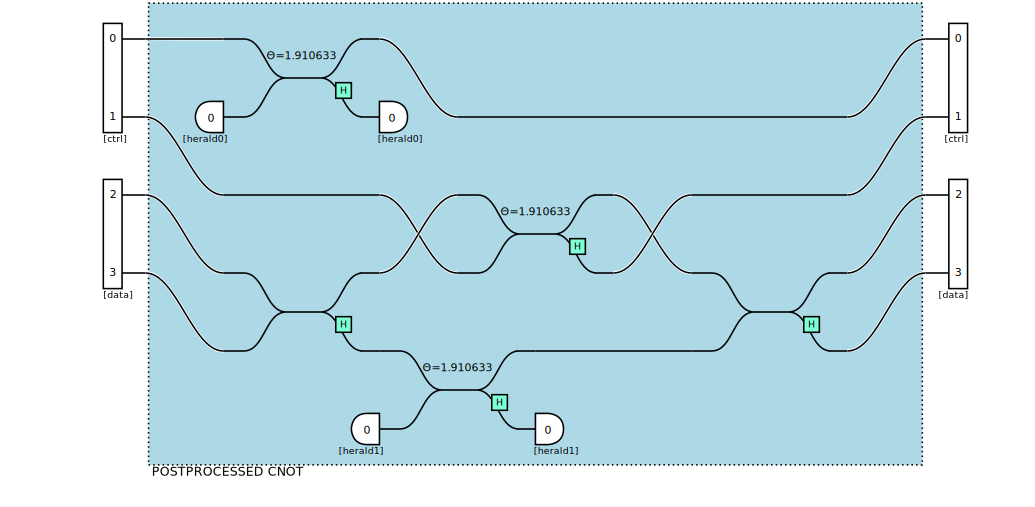

In [26]:
## Ralph's et al. CNot

print(catalog['postprocessed cnot'].doc)
ralph_cnot = catalog['postprocessed cnot'].as_processor().build()
## You can set its input state with a LogicalState
ralph_cnot.with_input(pcvl.BasicState([0, 1, 1, 0]))

pcvl.pdisplay(ralph_cnot, recursive=True, render_size=1.25)

In [ ]:
## TO-DO: Check/Convince yourself that the circuit above is performing a CNOT in the dual rail encoding

In [27]:
## You can sample some output states
ralph_cnot.min_detected_photons_filter(0)
cnot_sampler = pcvl.algorithm.Sampler(ralph_cnot)
samples = cnot_sampler.probs()
print(samples['results'])
print("Some output states were not selected because of heralds and post-processing => you can check the logical performance")
print("Logical performance = ", samples['logical_perf'])

{
  |0,1,0,1>: 1.0
}
Some output states were not selected because of heralds and post-processing => you can check the logical performance
Logical performance =  0.11111111111111131


In [28]:
## You can sample some output states
h_cnot = catalog['heralded cnot'].as_processor().build()
cnot_sampler = pcvl.algorithm.Sampler(h_cnot)
h_cnot.with_input(pcvl.LogicalState([0, 0]))

samples = cnot_sampler.samples(10)
print(samples['results'])
print("Some output states were not selected because of heralds and post-processing => you can check the logical performance")
print("Logical performance =", samples['logical_perf'])

[|1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>]
Some output states were not selected because of heralds and post-processing => you can check the logical performance
Logical performance = 0.05156442163200023


In [ ]:
## TO-DO: Check it perfoms a CNOT, and explicit the difference between the two types of CNOT

### Exercise

The next circuit comes from the following [paper](https://quantum-journal.org/papers/q-2021-03-29-422/).

![](../_static/img/tuto_circuit_to_reproduce.png)

In [ ]:
# TO-DO : reproduce it in the encoding seen above

#...

### Graph states

Graph states can be generated from a `networkx` graph with the `StateGenerator` class from Perceval.

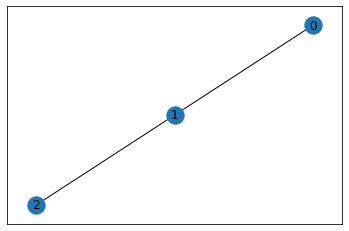

In [29]:
import networkx as nx

g = nx.Graph()
g.add_nodes_from([0, 1, 2])
g.add_edge(0, 1)
g.add_edge(1, 2)

nx.draw_networkx(g, with_labels=True)

In [30]:
# Set the generator with the dual rail encoding
generator = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
graph_state = generator.graph_state(g)
print(graph_state)

sqrt(2)/4*|0,1,1,0,1,0>+sqrt(2)/4*|1,0,1,0,1,0>-sqrt(2)/4*|0,1,0,1,1,0>+sqrt(2)/4*|1,0,0,1,1,0>+sqrt(2)/4*|0,1,1,0,0,1>+sqrt(2)/4*|1,0,1,0,0,1>+sqrt(2)/4*|0,1,0,1,0,1>-sqrt(2)/4*|1,0,0,1,0,1>


This graph state is a Perceval `StateVector`. It can be used as an input in any local computation, using `Processor.with_input()`. When a StateVector is input in a processor, it overrides any noisy source you might have set and is treated as a perfect input.

Also, a state vector cannot be input in any remote simulator or QPU.

In [31]:
p = pcvl.Processor("SLOS", pcvl.Unitary(pcvl.Matrix.random_unitary(6)))  # Use a 6x6 random unitary matrix as a circuit
p.with_input(graph_state)
sampler = Sampler(p)
print(sampler.probs()['results'])

{
  |3,0,0,0,0,0>: 0.012067367604486512
  |2,1,0,0,0,0>: 0.005945675462345662
  |2,0,1,0,0,0>: 0.012716631729857594
  |2,0,0,1,0,0>: 0.012693562894782661
  |2,0,0,0,1,0>: 0.030156852042383674
  |2,0,0,0,0,1>: 0.00580276487639313
  |1,2,0,0,0,0>: 0.00720247049179113
  |1,1,1,0,0,0>: 0.008188217313016676
  |1,1,0,1,0,0>: 0.046262825686439586
  |1,1,0,0,1,0>: 0.007995758248785267
  |1,1,0,0,0,1>: 0.009852022864218041
  |1,0,2,0,0,0>: 0.05430122986076079
  |1,0,1,1,0,0>: 0.03779833978425009
  |1,0,1,0,1,0>: 0.008077844832009896
  |1,0,1,0,0,1>: 0.013354751099243806
  |1,0,0,2,0,0>: 0.01801750998442593
  |1,0,0,1,1,0>: 0.03250390564690789
  |1,0,0,1,0,1>: 0.006064500964473524
  |1,0,0,0,2,0>: 0.001177037927901653
  |1,0,0,0,1,1>: 0.06611246846783118
  |1,0,0,0,0,2>: 0.012258040002959738
  |0,3,0,0,0,0>: 0.037092142534197195
  |0,2,1,0,0,0>: 0.011675676262495566
  |0,2,0,1,0,0>: 0.012102373473949768
  |0,2,0,0,1,0>: 0.0010900139813793165
  |0,2,0,0,0,1>: 0.016740388318542142
  |0,1,2,0,0,0>: